In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt

from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership


from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Entropy


In [16]:
df = pd.read_excel('Rice_Price_Inflation.xlsx')

train = df[:] #87
test = df[:]

In [17]:
np.max(train)

DATE              2021-10-15 00:00:00
PRICE                         37000.0
INFLATION                       18.72
FOOD INFLATION                  22.95
SECURITY INDEX                    9.9
dtype: object

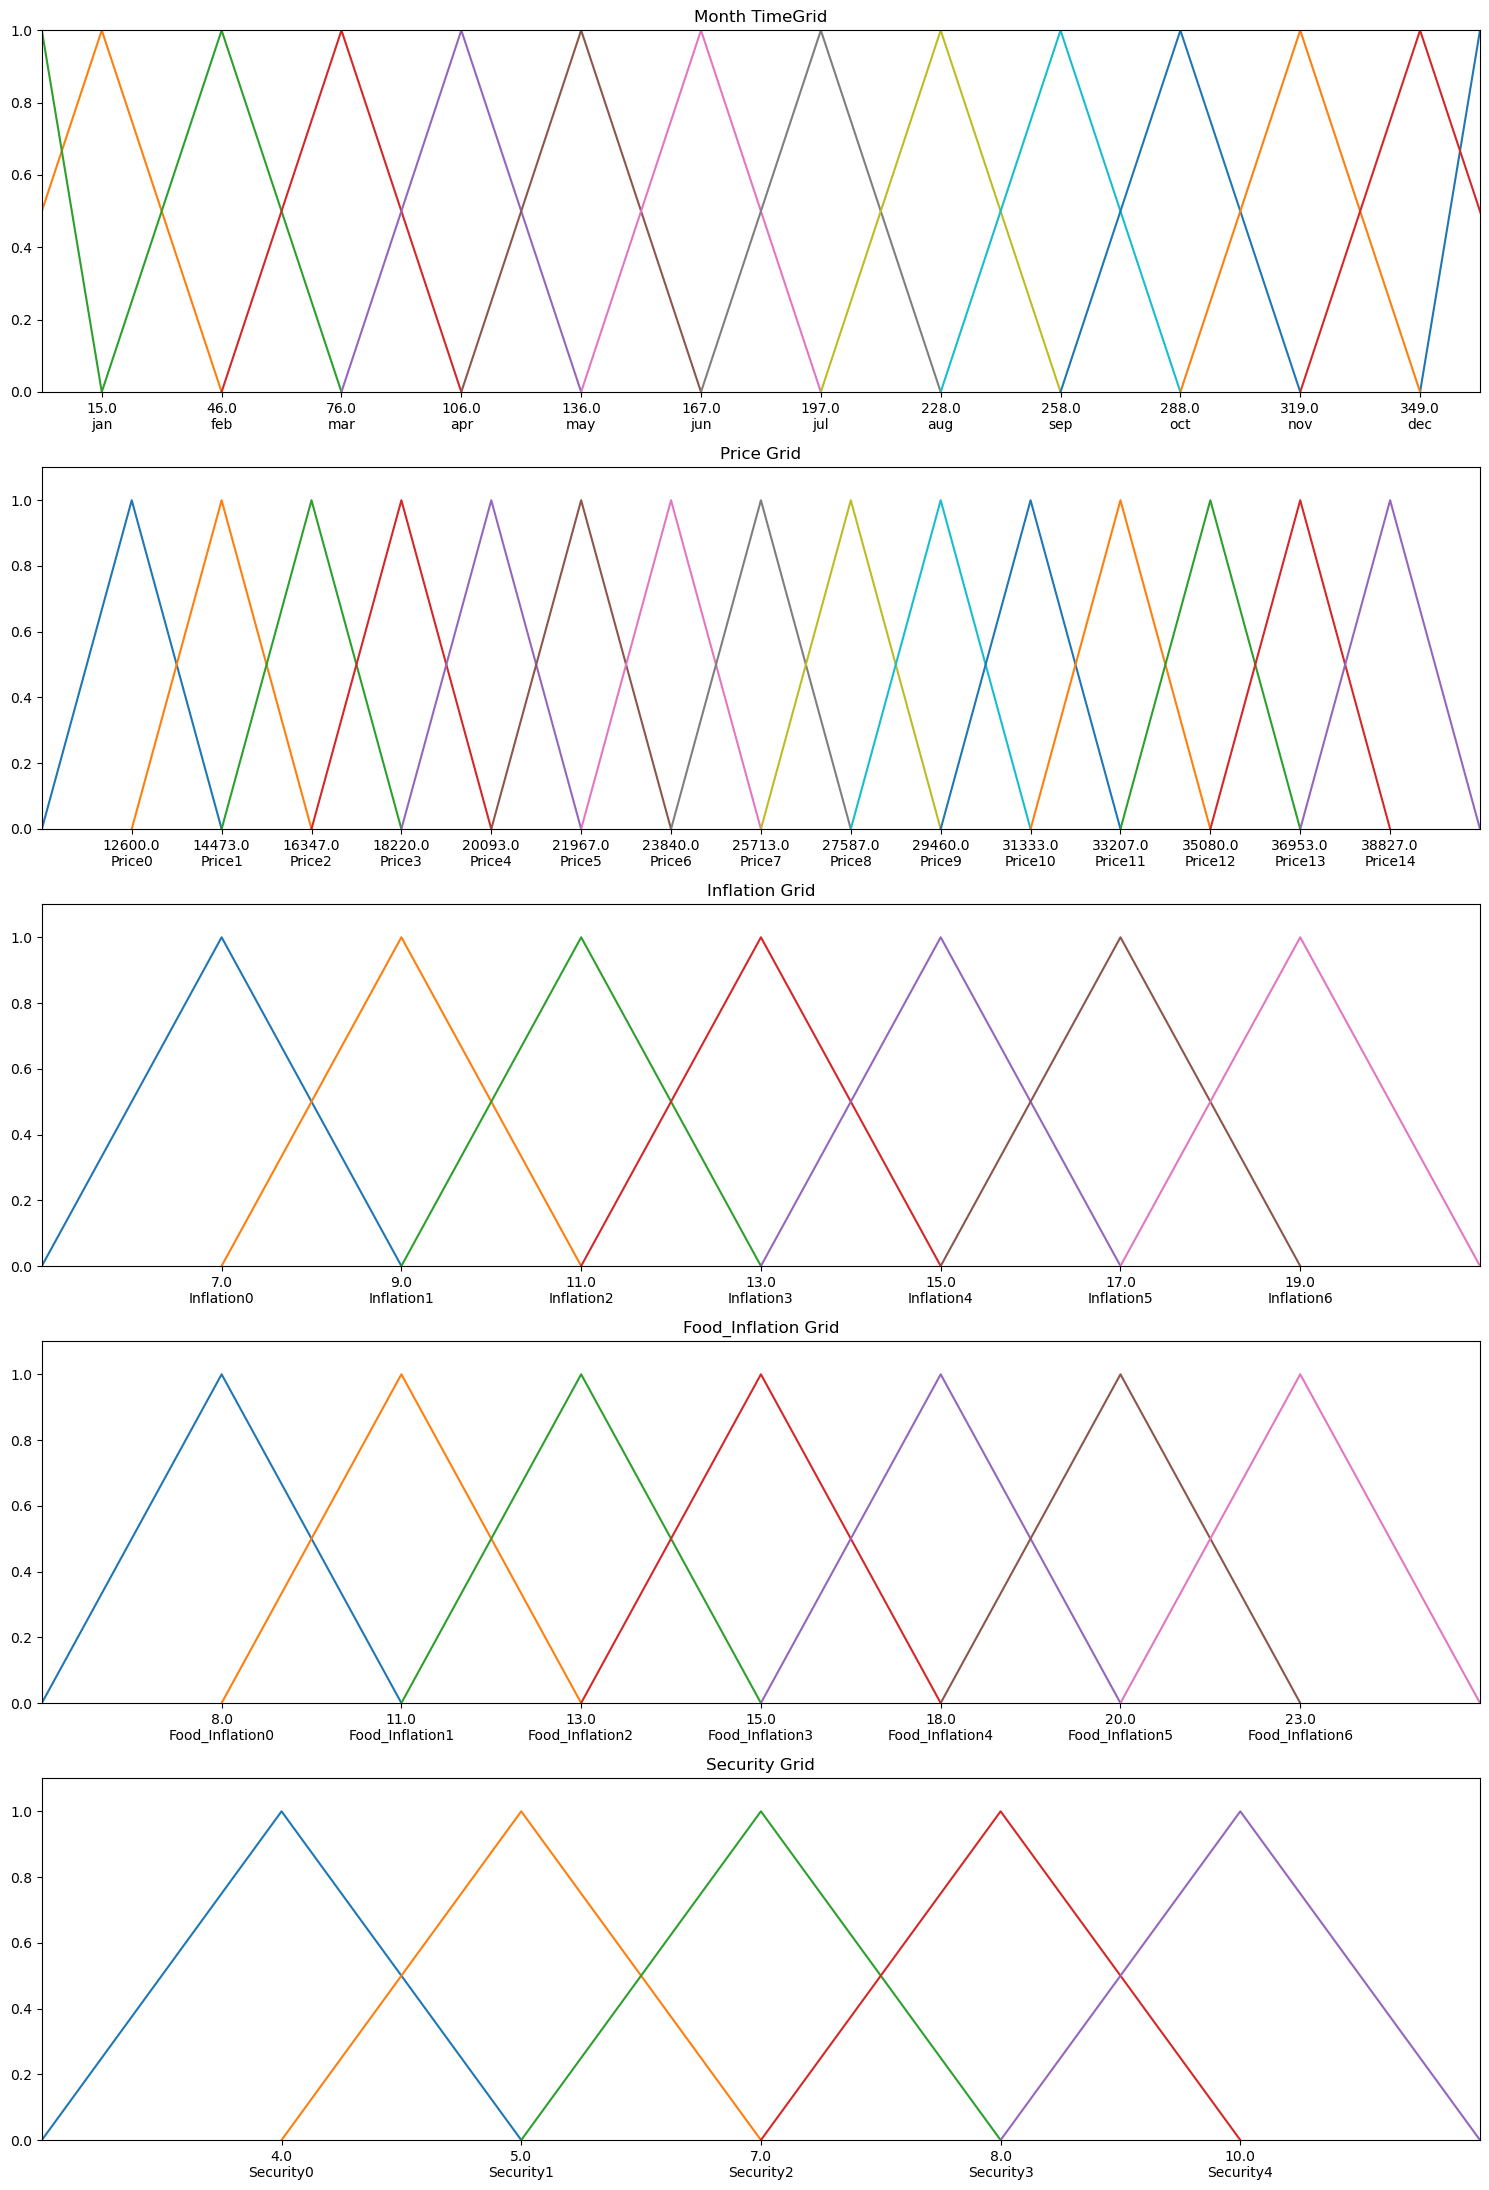

In [18]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=[15,22])

sp = {'seasonality': DateTime.day_of_year, 'names': ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']}
#sp = {'seasonality': DateTime.month, 'names': ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']}

vmonth = variable.Variable("Month", data_label="DATE", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                            data=train, partitioner_specific=sp) #func=Membership.trapmf

vmonth.partitioner.plot(ax[0])

vprice = variable.Variable("Price", data_label="PRICE", partitioner=Grid.GridPartitioner, npart=15, 
                            data=train) #func=Membership.trapmf,
vprice.partitioner.plot(ax[1])

vinflation = variable.Variable("Inflation", data_label="INFLATION", partitioner=Grid.GridPartitioner, npart=7,
                            data=train) #func=Membership.trapmf
vinflation.partitioner.plot(ax[2])

vfoodinflation = variable.Variable("Food_Inflation", data_label="FOOD INFLATION", partitioner=Grid.GridPartitioner,
                            npart=7, data=train) #func=Membership.trapmf
vfoodinflation.partitioner.plot(ax[3])

vsecurity = variable.Variable("Security", data_label="SECURITY INDEX", partitioner=Grid.GridPartitioner,
                            npart=5, data=train) #func=Membership.trapmf
vsecurity.partitioner.plot(ax[4])

plt.tight_layout()


In [19]:
# build the model

from pyFTS.models.multivariate import mvfts, wmvfts, cmvfts, grid


model = wmvfts.WeightedMVFTS(explanatory_variables=[vmonth, vinflation,  vprice], target_variable=vprice)
model.fit(train)

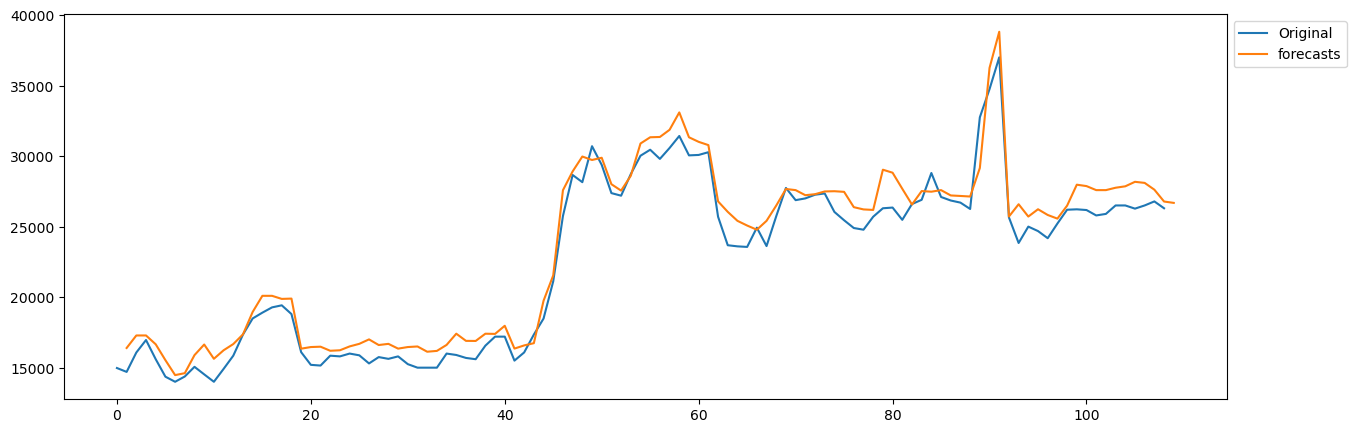

In [97]:
# one step aahead model forecast

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(train.PRICE,label='Original')

forecasts = model.predict(train)

forecasts.insert(0,None)

ax.plot(forecasts,label='forecasts')


handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [57]:
pred = np.array(forecasts)
#pred = pred[1:]

[None, 16395.48918661409, 17283.333333333336]

In [73]:
Actual = test.PRICE
len(Actual)

109

In [82]:
from tabulate import tabulate
headers = ['number','Actual', 'pred']

number = range(1, len(pred)+1)

table = zip(number, Actual, pred)

print(tabulate(table, headers=headers, floatfmt=".2f"))

  number    Actual      pred
--------  --------  --------
       1  14700.00  16395.49
       2  16075.00  17283.33
       3  16960.00  17283.33
       4  15600.00  16656.79
       5  14360.00  15532.38
       6  14000.00  14473.33
       7  14375.00  14609.97
       8  15060.00  15890.47
       9  14525.00  16641.78
      10  14000.00  15629.77
      11  14912.50  16232.70
      12  15850.00  16673.63
      13  17350.00  17361.21
      14  18490.00  18951.04
      15  18900.00  20093.33
      16  19275.00  20093.33
      17  19420.00  19874.77
      18  18800.00  19896.98
      19  16100.00  16346.67
      20  15200.00  16462.04
      21  15150.00  16487.01
      22  15850.00  16198.04
      23  15800.00  16233.19
      24  16000.00  16506.97
      25  15875.00  16690.17
      26  15300.00  17004.72
      27  15750.00  16605.29
      28  15625.00  16688.23
      29  15800.00  16350.64
      30  15250.00  16462.38
      31  15000.00  16503.04
      32  15000.00  16130.54
      33  1500

In [85]:
data = {'Actual_Price': Actual,
        'Predicted_Price': pred}

In [86]:
result = pd.DataFrame(data, columns=["Actual_Price", "Predicted_Price"])


In [87]:
result.shape

(108, 2)

In [88]:
result.head(3)

,Actual_Price,Predicted_Price
1,14700.0,16395.489187
2,16075.0,17283.333333
3,16960.0,17283.333333


In [23]:
new_forecasts = list(filter(lambda x: x is not None, forecasts))

#print(new_forecasts)



In [24]:
from math import nan
import math

newList = [element for element in new_forecasts if not math.isnan(element)]

print(newList)

[26716.610566338277, 26826.442740280272, 32750.0, 27657.22668701331, 24340.420178661752, 25133.980472265746, 24725.053114704904, 24129.363910858752, 25669.421138345137, 27036.84264017143, 26254.52410909091, 26175.0, 25791.670000000002, 26156.46863342112, 26987.111664961158, 27618.120675212358, 26911.984775069093, 26307.641285230213, 26815.668014194354, 26026.35611675189]


In [25]:
len(newList)

20

In [ ]:
from statsmodels.tools.eval_measures import rmse
error=rmse(newList, test['PRICE'])

In [11]:
from pandas.tseries.offsets import DateOffset

pred_dates = df['DATE'].iloc[-1]

pred_dates + DateOffset(months=24)

Timestamp('2023-10-15 00:00:00')

In [12]:
pred_dates

Timestamp('2021-10-15 00:00:00')

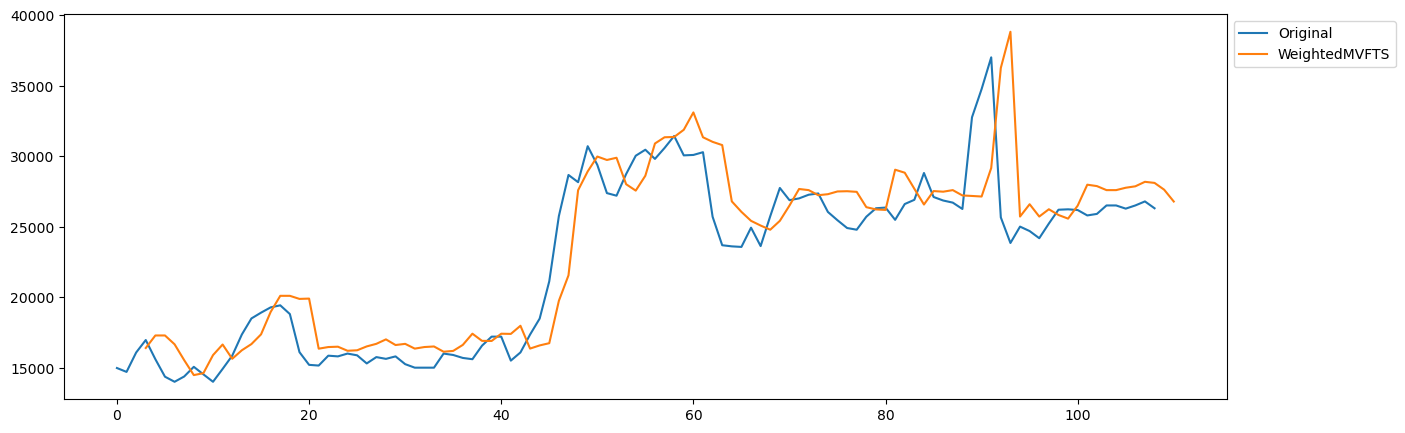

In [96]:
# Forecast ahead with naive price generator
import datetime

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])

ax.plot(test.PRICE,label='Original')


time_generator = lambda x : pd.to_datetime(x) + pd.Timedelta(720, unit='h')
price_generator = lambda x : x
inflation_generator = lambda x: x

forecasts_ahead = model.predict(test, steps_ahead=24, 
                          generators={'DATE': time_generator, 'PRICE': price_generator,
                                        'INFLATION': inflation_generator})
for k in np.arange(model.order):
  forecasts.insert(0,None)

ax.plot(pred, label=model.shortname)
  
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [94]:
forecasts_ahead

[26680.903639866025,
 27792.289828492285,
 28416.602262675562,
 29364.47880311338,
 29827.528700491963,
 30510.821541751033,
 31445.116487016145,
 31524.982880140014,
 31333.333333333336,
 31333.33296288334,
 30869.535394135582,
 28034.57413588975,
 27127.791890110555,
 27570.899692825464,
 28075.292077067945,
 29116.890593877164,
 29620.431656915687,
 30365.957132251715,
 31410.99988296838,
 31616.240707691933,
 31333.33333333334,
 31333.333039003177,
 30963.548448776335,
 28562.683407276203]

In [30]:
len(forecasts_ahead)

24

In [ ]:
my_price = test.iloc[:,1][2:]
#my_price.shape
len(newList)

In [15]:
from pyFTS.benchmarks.Measures import mape, rmse

mape_result = Measures.mape(pred, Actual)
mape_result

1.4250676309786885

Calculate the root mean squared error

In [62]:
result_new = result.dropna()
result_new = result_new.reset_index(drop=True)


In [ ]:

sum_error = 0.0
for i in range(len(result_new)):
    
    prediction_error = result_new['Predicted_Price'][i] - result_new['Actual_Price'][i]
    #print(prediction_error)
    sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(result_new))
solution = np.sqrt(mean_error)

In [67]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(result_new.Predicted_Price, result_new.Actual_Price)

{'mape': 0.014773951294626494,
 'me': 330.62283612853423,
 'mae': 382.02870484444867,
 'mpe': 0.012808833973756437,
 'rmse': 616.8820372814789}